import all the needed libraries

In [98]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import time
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Select the two photos of your choice,copy the images as "copy as path" and put it here.We will futhuer write a function that will load the image from the image path.

In [99]:
content_path = "C:\\Users\kumar\\OneDrive\\Desktop\\ayushhh-PhotoRoom.jpg"
style_path = "D:\\new phone photos\\20230630_210316.jpg"

From here preprocessing starts,we will aslo resize the images(changes their dimensions)

In [103]:
def load_converted_img(give_path):
    max_dim = 512
    converted_img = tf.io.read_file(give_path)
    converted_img = tf.image.decode_image(converted_img, channels=3)
    converted_img = tf.image.convert_image_dtype(converted_img, tf.float32)  ##  use float 32
    shape = tf.cast(tf.shape(converted_img)[:-1], tf.float32)
    take_max_shape = max(shape)
    scale = max_dim / take_max_shape
    new_shape = tf.cast(shape * scale, tf.int32)
    converted_img = tf.image.resize(converted_img, new_shape)
    converted_img = converted_img[tf.newaxis, :]
    return converted_img

I also wrote a function to show the image

In [110]:

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

Show the images using matplotlib

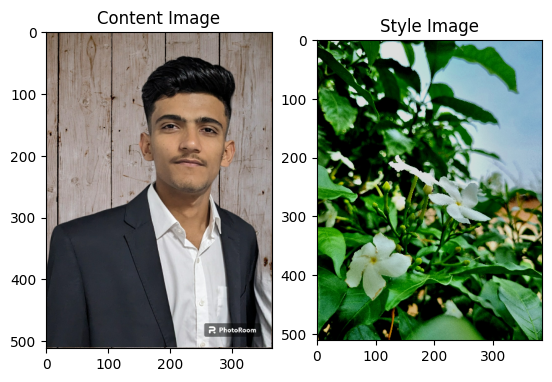

In [111]:
content_image = load_converted_img(content_path)
style_image = load_converted_img(style_path)
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

We will now create a random image.This image will be modified later such that it has content similar to the content image and style similar to style image. This image will have a size(dimensions) similar to the content and style image.

 Now we will be sending this maintianed data to our neural network. We will be using Transfer Learning.We have many models which are pre-trained on large image dataset. These models have learnt to extract the features from the image. These learning have been stored in the form of the weights that we will be using. We will simply use them to extract the style and content of our images. Here, we will be using a popular VGG19 network(upgradation of vgg16).
 
This is the typical VGG-19 network.
 INPUT--CONV--CONV--MAXPOOL--CONV--CONV--MAXPOOL--CONV--CONV--CONV-CONV--MAXPOOL-CONV--CONV--CONV--CONV--MAXPOOL--FULLYCONNCETED--FULLYCONNECTED--FULLYCONNCETED--SOFTMAX--OPUTPUT

 Every time kernel/filter size is 3*3 and  during a convolutional layer network uses a stride of 1 and during a maxpooling layer network uses a stride of 2. Activation is everytime relu activation(which is preferrable most of the times)(also padding is kept same)

Here is inside of vgg 16   implementation  from scratch (just for feel of whats going inside)

In [112]:
def VGG16():
  model = Sequential()
  model.add(Conv2D(filters = 64, kernel_size=(3,3), strides = 1, padding='same', input_shape = (224,224,3), activation = 'relu'))
  model.add(Conv2D(filters = 64, kernel_size=(3,3),strides = 1, padding='same', activation = 'relu'))
  model.add(MaxPool2D(pool_size = (2,2),strides = 2))
  model.add(Conv2D(filters = 128, kernel_size=(3,3),strides = 1, padding='same', activation = 'relu'))
  model.add(Conv2D(filters = 128, kernel_size=(3,3),strides = 1, padding='same', activation = 'relu'))
  model.add(MaxPool2D(pool_size = (2,2),strides = 2))
  model.add(Conv2D(filters = 256, kernel_size=(3,3),strides = 1, padding='same', activation = 'relu'))
  model.add(Conv2D(filters = 256, kernel_size=(3,3),strides = 1, padding='same', activation = 'relu'))
  model.add(Conv2D(filters = 256, kernel_size=(3,3),strides = 1, padding='same', activation = 'relu'))
  model.add(MaxPool2D(pool_size = (2,2),strides = 2))
  model.add(Conv2D(filters = 512, kernel_size=(3,3),strides = 1, padding='same', activation = 'relu'))
  model.add(Conv2D(filters = 512, kernel_size=(3,3),strides = 1, padding='same', activation = 'relu'))
  model.add(Conv2D(filters = 512, kernel_size=(3,3),strides = 1, padding='same', activation = 'relu'))
  model.add(MaxPool2D(pool_size = (2,2),strides = 2))
  model.add(Conv2D(filters = 512, kernel_size=(3,3),strides = 1, padding='same', activation = 'relu'))
  model.add(Conv2D(filters = 512, kernel_size=(3,3),strides = 1, padding='same', activation = 'relu'))
  model.add(Conv2D(filters = 512, kernel_size=(3,3),strides = 1, padding='same', activation = 'relu'))
  model.add(MaxPool2D(pool_size = (2,2),strides = 2))
  model.add(Flatten())
  model.add(Dense(units = 4096,activation = 'relu'))
  model.add(Dense(units = 4096,activation = 'relu'))
  model.add(Dense(units = 1000,activation = 'softmax'))
  return model

Here is detailed vgg19 network implementaion that we will be using in our project.

In [113]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
 
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    return x
 
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
 
def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)
 
    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
 
    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg19.get_layer("block3_conv4").output         ## (128 x 128)
    s4 = vgg19.get_layer("block4_conv4").output         ## (64 x 64)
 
    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         ## (32 x 32)
 
    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
 
    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
 
    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model
 

Obviously there are more than 3 crore parameters to train  which will require any powerfull chip(like nvidia) to train, that will also took weeks to train.

I will be using them directly from library

Taking vgg 19 model without the later output layers.
Include_top=false means you don't want to include the final layers.
Here we are not doing the image classification(type of unsupervised learning),so we do not need the final dense and fully connected layers and hence we are using include_top = false.

In [114]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet') 

For refernce and better understanding,we can see vgg network layers

In [115]:
for layer in vgg.layers:
  print(layer.name)

input_layer_8
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


OK ,so here is how we are going to select layers for content material and style material.We will take them out from different CNN layers.
 As we move deeper into the network these features get more complex and near the final CNN layers, the best feature representation of the image is found. So, we will take a layer from the final block of the model for content extraction as it represents the feature of the image well. So as we are taking the block5_conv2 layer.

Below is the extraction of the content.

In [116]:
content_layers = ['block5_conv2']
num_content_layers = len(content_layers)

Below is the extraction of the style.

As network moves throgh the layers,it keep learning new features.The number of channels in the output of a filter is equal to the number of features learnt at that layer. In the starting layers, the network learns simple features such as detecting horizontal, vertical or diagonal lines in the first layer and detecting corners in the next layer and so on. As at each layer some of the other patterns are being detected therefore we will use multiple layers( one from each block) to extract the style information. In our case, we will be using [‘block1_conv1’, ‘block2_conv1’,’block3_conv1', ‘block4_conv1’, ‘block5_conv1’].

In [117]:
style_layers =['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
num_style_layers = len(style_layers)

Vgg_layers FUNCTION, Creates a vgg model that returns a list of intermediate output values.

In [118]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

Now the turn of losses.We need to calculate total losses (content and style)

Content Loss: It is used to check how much the generated image is similar to our content image. We know that the information about the content of any image will be simply given by the activations of the neurons in different layers. It is simply calculated as the euclidean distance between the activations or feature representation of content and generated images at different layers(similar to loss function in linear regression).

Style loss:  It is interesting part to calculate as we can not just find euclidean distances and compute loss.We have to find the co-reraltion between them  and how much two thing co-relate to each other can easily be determined using the dot product of them.The high the dot product,highly they are corelated which is (summation(a(i)*b(i)) from i =0 to i =n)

We will use the Gram Matrix to measure the degree of correlation between channels which later will act as a measure of the style itself.
which is  summation(original_matrix * transposed_matrix)

gram matrix will simply be  a AAt(WHICH IS matrix(A) * matrix(A TRANSPOSE))

In [86]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations


Now we were just comparing style of two images.We will now have gram matrix for both the images and we can now easily compute the summation of square of differences between them(same as linear regression)

calculating both style and content losses

In [119]:
def style_content_loss(outputs, style_targets, content_targets):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)
    total_loss = style_loss + content_loss
    return total_loss


Here is some special loss apart from content and style loss that is variation Loss ,we notice that reducing only the style and content losses led to highly noisy outputs and to reduce that noise, variation loss was also included in the total_loss of NST. This loss ensures spatial continuity and smoothness in the generated image to avoid noisy and overly pixelated results. This is done by finding the difference between the neighbour pixels.

In [120]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    return x_var, y_var
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)


The total loss is the weighted sum of these three losses.

These weights decide how much impact will style or content will have on the total loss.If you want to have more style than content in the resultant image, put a higher weight on the style loss which makes the total loss to be more dependent on style loss and optimizing total loss will focus more on optimizing style loss. Hence making the resultant image more similar to style image than content image.

Assign weights

In [121]:
style_weight=1e-2
content_weight=1e4
total_variation_weight=1e8

Now we need a optimizer,we will use adam optimizer.It will try to reduce the loss by changing parameters everytime

Keep aplha(learning rate) small.

In [122]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [123]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style': style_dict}

In [124]:
extractor = StyleContentModel(style_layers, content_layers)

In [125]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [126]:
image = tf.Variable(content_image, dtype=tf.float32)

In [127]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [128]:
@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets)
        loss += total_variation_weight * total_variation_loss(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return loss

I have ran the algorithm by taking final image as the random intializer with same dimensions of the content andd style image.Where i run the model and from starting onwards i was getting 80 crore loss  which was way high  and i find out that to give a good NST image it will take approx 37 hours.So insted i started with the content image as the generated image from starting which will obviously make sense that already loss is less and also it will work better and it also came out to be true  when i start running the model the starting loss was approx 7 crore and was decreasing in every epochs and it gave me a good final image.

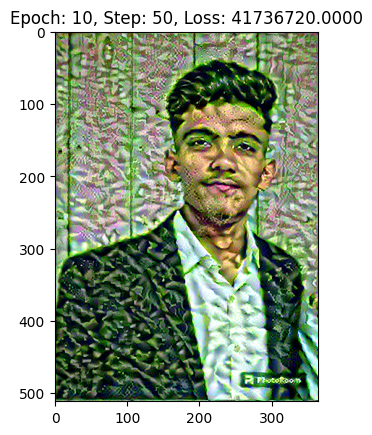

Total time: 71.5 seconds


In [129]:
def neural_style_transfer(): 
    start = time.time()
    epochs = 10
    steps_per_epoch = 5
    step = 0

    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            loss = train_step(image)
            print(f"Epoch {n + 1}/{epochs}, Step {m + 1}/{steps_per_epoch}, Total Step: {step}, Loss: {loss:.4f}", end='\r')
        display.clear_output(wait=True)
        imshow(image.read_value())
        plt.title(f"Epoch: {n + 1}, Step: {step}, Loss: {loss:.4f}")
        plt.show()

    end = time.time()
    print("Total time: {:.1f} seconds".format(end - start))
neural_style_transfer()